In [22]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


One warehouse n stores real data(46 stores, 109 samples)
   store_underage_cost Architecture Class  train_n_samples  Train Loss  Dev Loss  Test Loss  Test Gap %
0                    8                GNN            32768    5.346495  5.345672   7.955832   47.711513
0                    8            GNN_pna            32768    5.393600  5.387563   5.386061    0.000000
0                    8         Vanilla NN            32768    5.390981  5.392766   5.396614    0.195945


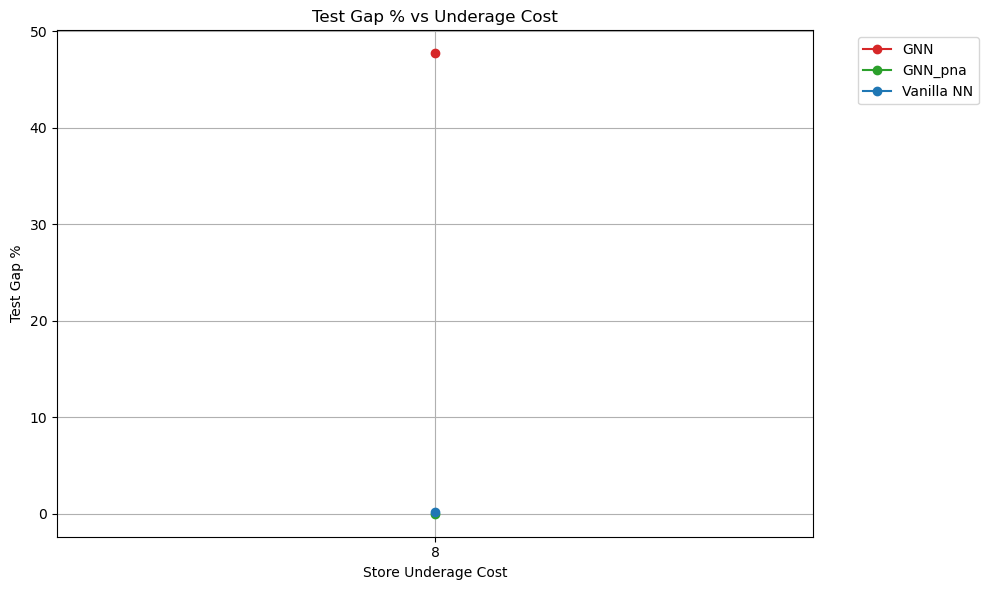

In [31]:
# Define color scheme for architecture types
color_scheme = {
    "GNN": "#d62728",  # red
    "GNN_pna": "#2ca02c",  # green
    "Vanilla NN": "#1f77b4",  # Blue
}

linestyle_scheme = {
    "GNN": "-",
    "GNN_pna": "-",
    "Vanilla NN": "-",
}

path = 'generic_architecture_n_warehouse'
gnn_paths = {
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/GNN',
}
gnn_pna_paths = {
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/GNN_pna',
}
vanilla_nn_paths = {
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/vanilla_n_warehouses',
}
def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
store_underage_cost = [8]
results_interpretor = rri.RayResultsinterpreter()

# GNN
df_gnn = results_interpretor.make_table(gnn_paths,
    {'store_underage_cost': store_underage_cost, 'train_n_samples': 32768},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn.insert(1, 'hyperparam_name', "GNN")

# GNN PNA
df_gnn_pna = results_interpretor.make_table(gnn_pna_paths,
    {'store_underage_cost': store_underage_cost, 'train_n_samples': 32768},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_pna.insert(1, 'Architecture Class', "GNN_pna")
df_gnn_pna.insert(1, 'hyperparam_name', "GNN_pna")

# Vanilla NN
df_vanilla = results_interpretor.make_table(vanilla_nn_paths,
    {'store_underage_cost': store_underage_cost, 'train_n_samples': 32768},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla.insert(1, 'Architecture Class', "Vanilla NN")
df_vanilla.insert(1, 'hyperparam_name', "vanilla_n_warehouses")

# Combine dataframes
df = pd.concat([
    df_gnn, df_gnn_pna, df_vanilla
])

min_test_loss = df.groupby(['store_underage_cost'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.drop(columns=['# of stores'], inplace=True)
df.sort_values(by=['store_underage_cost', 'Architecture Class'], inplace=True)
cols = df.columns.tolist()
cols.remove('store_underage_cost')
cols = ['store_underage_cost'] + cols
df = df[cols]

df_to_print = df.copy()
df_to_print.drop(columns=['hyperparam_name', 'Learning Rate', 'path', '# of runs'], inplace=True)
print("One warehouse n stores real data(46 stores, 109 samples)")
print(df_to_print.to_string())

# Create plot for Test Gap % vs Underage Cost
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for Test Gap % - take best performing one (highest Test Gap %) for each group
pivot_df = df.groupby(['store_underage_cost', 'Architecture Class'])['Test Gap %'].min().unstack()

for column in pivot_df.columns:
    ax.plot(pivot_df.index.to_numpy(), pivot_df[column].to_numpy(),
            marker='o',
            label=column,
            color=color_scheme[column],
            linestyle=linestyle_scheme[column])

ax.set_xlabel('Store Underage Cost')
ax.set_ylabel('Test Gap %')
ax.set_title('Test Gap % vs Underage Cost')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)
ax.set_xticks(pivot_df.index)

plt.tight_layout()
plt.show()

In [6]:
# Calculate average improvement of GNN_MP over other architectures in Dev Loss across all underage costs
architectures = ['Vanilla NN']
improvements = {}

for arch in architectures:
    # Get Dev Loss for each architecture and GNN_MP for all underage costs
    arch_losses = df[df['Architecture Class'] == arch]['Dev Loss']
    gnn_losses = df[df['Architecture Class'] == 'GNN']['Dev Loss']
    
    # Calculate relative improvement for each underage cost and average
    if not arch_losses.empty and not gnn_losses.empty:
        improvements = []
        for arch_loss, gnn_loss in zip(arch_losses, gnn_losses):
            improvement = ((arch_loss - gnn_loss) / arch_loss) * 100
            improvements.append(improvement)
        avg_improvement = sum(improvements) / len(improvements)
        print(f"GNN_MP improves {arch} by {avg_improvement:.2f}% in Dev Loss on average")

GNN_MP improves Vanilla NN by -3.82% in Dev Loss on average


One warehouse n stores real data(46 stores, 109 samples)
   store_underage_cost Architecture Class  train_n_samples  Train Loss  Dev Loss  Test Loss  Test Gap %
0                    8                GNN               16    5.326170  5.345250   5.750079    0.000000
0                    8         Vanilla NN               16    5.275868  6.227479   6.536829   13.682412


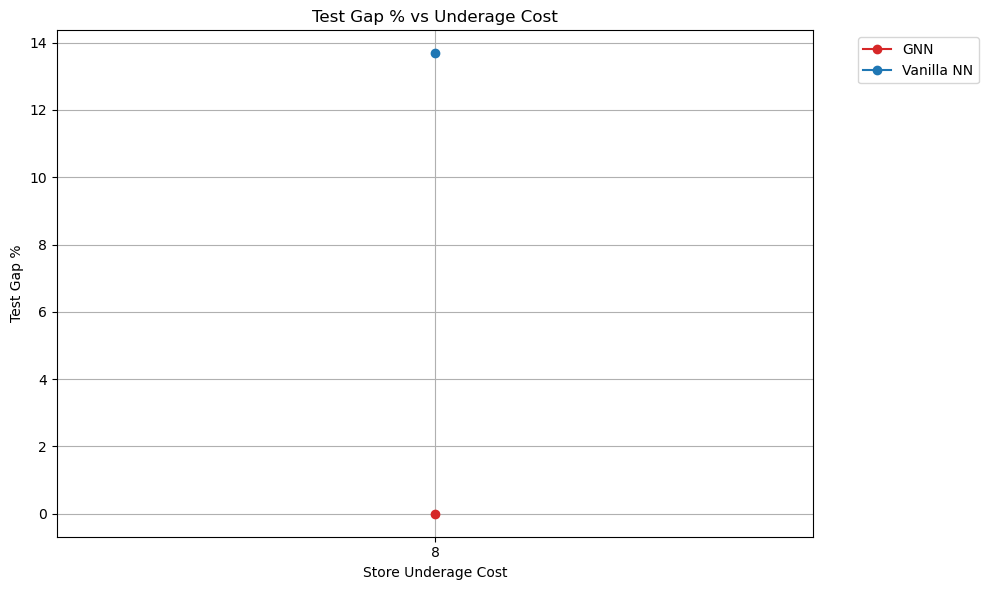

In [8]:
# Define color scheme for architecture types
color_scheme = {
    "GNN": "#d62728",  # red
    "Vanilla NN": "#1f77b4",  # Blue
}

linestyle_scheme = {
    "GNN": "-",
    "Vanilla NN": "-",
}

path = 'generic_architecture_n_warehouse'
gnn_paths = {
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/GNN',
}
vanilla_nn_paths = {
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/vanilla_n_warehouses',
}
def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
store_underage_cost = [8]
results_interpretor = rri.RayResultsinterpreter()

# GNN
df_gnn = results_interpretor.make_table(gnn_paths,
    {'store_underage_cost': store_underage_cost, 'train_n_samples': 16},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn.insert(1, 'hyperparam_name', "GNN")

# Vanilla NN
df_vanilla = results_interpretor.make_table(vanilla_nn_paths,
    {'store_underage_cost': store_underage_cost, 'train_n_samples': 16},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla.insert(1, 'Architecture Class', "Vanilla NN")
df_vanilla.insert(1, 'hyperparam_name', "vanilla_n_warehouses")

# Combine dataframes
df = pd.concat([
    df_gnn, df_vanilla
])

min_test_loss = df.groupby(['store_underage_cost'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.drop(columns=['# of stores'], inplace=True)
df.sort_values(by=['store_underage_cost', 'Architecture Class'], inplace=True)
cols = df.columns.tolist()
cols.remove('store_underage_cost')
cols = ['store_underage_cost'] + cols
df = df[cols]

df_to_print = df.copy()
df_to_print.drop(columns=['hyperparam_name', 'Learning Rate', 'path', '# of runs'], inplace=True)
print("One warehouse n stores real data(46 stores, 109 samples)")
print(df_to_print.to_string())

# Create plot for Test Gap % vs Underage Cost
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for Test Gap % - take best performing one (highest Test Gap %) for each group
pivot_df = df.groupby(['store_underage_cost', 'Architecture Class'])['Test Gap %'].min().unstack()

for column in pivot_df.columns:
    ax.plot(pivot_df.index.to_numpy(), pivot_df[column].to_numpy(),
            marker='o',
            label=column,
            color=color_scheme[column],
            linestyle=linestyle_scheme[column])

ax.set_xlabel('Store Underage Cost')
ax.set_ylabel('Test Gap %')
ax.set_title('Test Gap % vs Underage Cost')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)
ax.set_xticks(pivot_df.index)

plt.tight_layout()
plt.show()  

In [8]:
# Calculate average improvement of GNN_MP over other architectures in Dev Loss across all underage costs
architectures = ['Vanilla NN']
improvements = {}

for arch in architectures:
    # Get Dev Loss for each architecture and GNN_MP for all underage costs
    arch_losses = df[df['Architecture Class'] == arch]['Dev Loss']
    gnn_losses = df[df['Architecture Class'] == 'GNN']['Dev Loss']
    
    # Calculate relative improvement for each underage cost and average
    if not arch_losses.empty and not gnn_losses.empty:
        improvements = []
        for arch_loss, gnn_loss in zip(arch_losses, gnn_losses):
            improvement = ((arch_loss - gnn_loss) / arch_loss) * 100
            improvements.append(improvement)
        avg_improvement = sum(improvements) / len(improvements)
        print(f"GNN_MP improves {arch} by {avg_improvement:.2f}% in Dev Loss on average")

GNN_MP improves Vanilla NN by 17.89% in Dev Loss on average
